# План работ по курсовому проекту:

1. построить базовую модель
2. Обернуть в пайплайн
  - sclearn pipline
  - MLFlow с контролем метрик
    * опционально если успею подключить AirFlow
3. Обернут в REST API
  - Flask
  - Django
4. Собрать в контейнер Docker локально
5. Развернуть Docker на AWS

# Задача: построение предсказания качества вина (задача регрессии)

Исходные данные: https://www.kaggle.com/zynicide/wine-reviews

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size':12})

## Read dataset

In [16]:
path = './dataset/'
wine_150k = pd.read_csv(path + 'winemag-data_first150k.csv',index_col=0)
wine_130k = pd.read_csv(path + 'winemag-data-130k-v2.csv',index_col=0)
wine = pd.concat([wine_150k,wine_130k],axis=0)
print("Number of rows and columns:",wine.shape)

Number of rows and columns: (280901, 13)


In [3]:
wine.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'variety', 'winery', 'taster_name',
       'taster_twitter_handle', 'title'],
      dtype='object')

In [4]:
wine.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
variety                   object
winery                    object
taster_name               object
taster_twitter_handle     object
title                     object
dtype: object

In [5]:
wine.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,taster_name,taster_twitter_handle,title
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,NaN,NaN,NaN
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,NaN,NaN,NaN
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,NaN,NaN,NaN
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,NaN,NaN,NaN
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,NaN,NaN,NaN


In [24]:
wine.describe(include='all',).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,280833,50,US,116901,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,280901,169430,A little bit funky and unsettled when you pop ...,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
designation,197701,47239,Reserve,4761,NaN,NaN,NaN,NaN,NaN,NaN,NaN
points,280901.0,NaN,NaN,NaN,88.146934,3.151528,80.0,86.0,88.0,90.0,100.0
price,258210.0,NaN,NaN,NaN,34.177162,38.611708,4.0,16.0,25.0,40.0,3300.0
province,280833,490,California,80755,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_1,234594,1332,Napa Valley,10689,NaN,NaN,NaN,NaN,NaN,NaN,NaN
variety,280900,756,Pinot Noir,27563,NaN,NaN,NaN,NaN,NaN,NaN,NaN
winery,280901,19186,Williams Selyem,585,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# look at NaN
len(wine) - wine.count()

country                      68
description                   0
designation               83200
points                        0
price                     22691
province                     68
region_1                  46307
region_2                 169437
variety                       1
winery                        0
taster_name              177174
taster_twitter_handle    182143
title                    150930
dtype: int64

Пропусков многовато - взглянем визуально

In [23]:
def show_nan(df_name):
    """Function makes histogram of NaN in dataset
    :param df_name: name of dataset
    """
    nan_df_name = (df_name.isna().sum() / df_name.shape[0]).reset_index()
    nan_df_name.columns=['feature', 'nan_percent']

    plt.figure(figsize=(16,4))
    sns.barplot(x=nan_df_name['feature'], y=nan_df_name['nan_percent'])
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

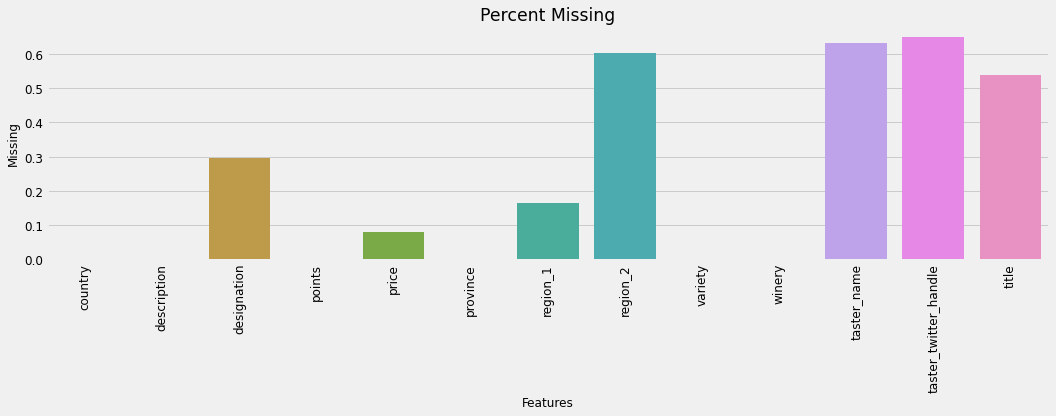

In [18]:
show_nan(wine)

In [19]:
wine.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'variety', 'winery', 'taster_name',
       'taster_twitter_handle', 'title'],
      dtype='object')

Большое число пропусков по полям ['region_2', 'taster_name', 'taster_twitter_handle', 'title']. Эти поля придется отбрасывать - заполнение повлечет сильное искажение данных.

In [20]:
features = ['country', 'description', 'designation', 'points', 'price', 'province', 'region_1',
            'variety', 'winery']

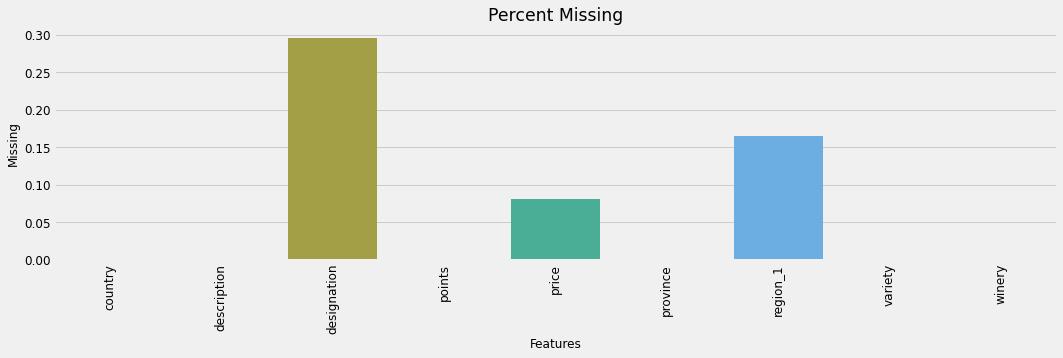

In [21]:
wine = wine[features]
show_nan(wine)

Посмотрим - может часть переменных удасться перевести в категории

In [37]:
for col in wine.select_dtypes(include='object'):
    print(f'column: {col}, \tuniques: {len(wine[col].unique())}')

column: country, 	uniques: 51
column: description, 	uniques: 169430
column: designation, 	uniques: 47240
column: province, 	uniques: 491
column: region_1, 	uniques: 1333
column: variety, 	uniques: 757
column: winery, 	uniques: 19186


Похоже только country можно перевести в категории - через one_hot_encoding

In [40]:
wine = pd.concat([wine.drop('country', axis=1), 
                          pd.get_dummies(wine['country'], prefix='country')], axis=1)
wine.head()

,description,designation,points,price,province,region_1,variety,winery,country_Albania,country_Argentina,...,country_South Africa,country_South Korea,country_Spain,country_Switzerland,country_Tunisia,country_Turkey,country_US,country_US-France,country_Ukraine,country_Uruguay
0,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Cabernet Sauvignon,Heitz,0,0,...,0,0,0,0,0,0,1,0,0,0
1,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,Tinta de Toro,Bodega Carmen Rodríguez,0,0,...,0,0,1,0,0,0,0,0,0,0
2,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sauvignon Blanc,Macauley,0,0,...,0,0,0,0,0,0,1,0,0,0
3,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Pinot Noir,Ponzi,0,0,...,0,0,0,0,0,0,1,0,0,0
4,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,Provence red blend,Domaine de la Bégude,0,0,...,0,0,0,0,0,0,0,0,0,0
